In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install supervision
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [3]:
import zipfile
import os
import glob
import shutil
import yaml
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from shapely.geometry import box
from sklearn.model_selection import train_test_split
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
zip_path = "/content/drive/MyDrive/Work/SRIP/AISustainability/labels-20250212T103318Z-001.zip"
extract_path = "/content/extracted_label_files"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipping complete! Files are extracted to:", extract_path)


Unzipping complete! Files are extracted to: /content/extracted_label_files


**Dataset statistics **

How many instances of solar panels are present in the dataset?

Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.


In [5]:
def count_solar_panels(labels_dir):
    total_panels = 0
    files_with_panels = 0
    panels_per_file = {}
    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))
    total_files = len(label_files)
    for label_file in label_files:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            num_panels = len(lines)
            if num_panels > 0:
                files_with_panels += 1
            total_panels += num_panels
            file_name = os.path.basename(label_file)
            panels_per_file[file_name] = num_panels

    return total_panels, panels_per_file, files_with_panels, total_files

def analyze_panel_distribution(panels_per_file):
    panel_counts = list(panels_per_file.values())

    stats = {
        'max_panels': max(panel_counts),
        'min_panels': min(panel_counts),
        'avg_panels': sum(panel_counts) / len(panel_counts) if panel_counts else 0
    }

    return stats

In [6]:

native_labels_dir = "/content/extracted_label_files/labels/labels_native"
total_panels, panels_per_file, files_with_panels, total_files = count_solar_panels(native_labels_dir)
stats = analyze_panel_distribution(panels_per_file)

print(f"Total number of solar panel instances: {total_panels}")
print(f"Number of files containing panels: {files_with_panels} out of {total_files}")
print(f"\nDistribution statistics:")
print(f"Maximum panels in a single image: {stats['max_panels']}")
print(f"Minimum panels in a single image: {stats['min_panels']}")
print(f"Average panels per image: {stats['avg_panels']:.2f}")

Total number of solar panel instances: 29625
Number of files containing panels: 2542 out of 2542

Distribution statistics:
Maximum panels in a single image: 78
Minimum panels in a single image: 1
Average panels per image: 11.65


In [7]:
def analyze_label_distribution(labels_dir):
    labels_per_file = {}

    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))
    for label_file in label_files:
        with open(label_file, 'r') as f:
            num_labels = len(f.readlines())
            labels_per_file[os.path.basename(label_file)] = num_labels
    distribution = Counter(labels_per_file.values())
    sorted_dist = dict(sorted(distribution.items()))

    return sorted_dist, labels_per_file

def visualize_distribution(distribution):
    plt.figure(figsize=(12, 6))
    plt.bar(distribution.keys(), distribution.values())
    plt.xlabel('Number of Solar Panels per Image')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Solar Panel Labels per Image')
    plt.grid(True, alpha=0.3)
    return plt

In [8]:
labels_dir = "/content/extracted_label_files/labels/labels_native"
distribution, labels_per_file = analyze_label_distribution(labels_dir)
df = pd.DataFrame(list(distribution.items()), columns=['Labels_per_Image', 'Number_of_Images'])
df = df.sort_values('Labels_per_Image')
total_images = sum(distribution.values())
df['Percentage'] = (df['Number_of_Images'] / total_images * 100).round(2)
df['Cumulative_Percentage'] = df['Percentage'].cumsum().round(2)

Distribution of Solar Panel Labels per Image:
 Labels_per_Image  Number_of_Images  Percentage  Cumulative_Percentage
                1                81        3.19                   3.19
                2               167        6.57                   9.76
                3               221        8.69                  18.45
                4               218        8.58                  27.03
                5               217        8.54                  35.57
                6               189        7.44                  43.01
                7               170        6.69                  49.70
                8               184        7.24                  56.94
                9               169        6.65                  63.59
               10               121        4.76                  68.35
               11                97        3.82                  72.17
               12                84        3.30                  75.47
               13              

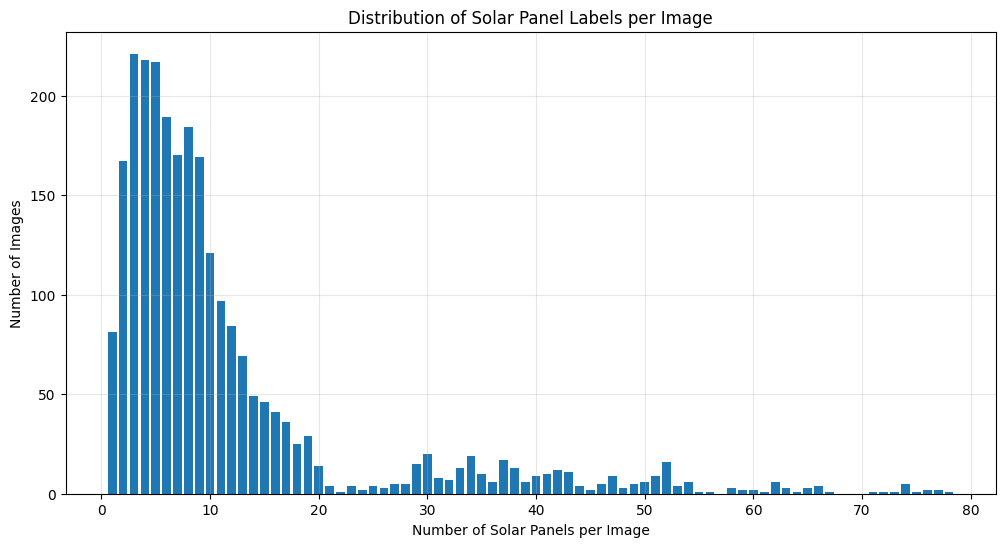

In [9]:
# Printing detailed statistics
print("Distribution of Solar Panel Labels per Image:")
print("=" * 80)
print(df.to_string(index=False))
print("\nSummary Statistics:")
print(f"Total number of images: {total_images}")
print(f"Maximum labels in a single image: {df['Labels_per_Image'].max()}")
print(f"Average labels per image: {sum(x * y for x, y in distribution.items()) / total_images:.2f}")

fig = visualize_distribution(distribution)
plt.show()


In [10]:
# Additional analysis of label density
non_zero_labels = {k: v for k, v in distribution.items() if k > 0}
print(f"\nImages with at least one solar panel: {sum(non_zero_labels.values())}")
print(f"Images with no solar panels: {distribution.get(0, 0)}")
print(f"Percentage of images containing solar panels: {(sum(non_zero_labels.values()) / total_images * 100):.2f}%")


Images with at least one solar panel: 2542
Images with no solar panels: 0
Percentage of images containing solar panels: 100.00%


**Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)**

  What method was used to compute the area (in meters) for a single instance?

  What is the mean area and standard deviation?

  Plot the histogram of areas. What do you observe?


In [11]:
def compute_panel_areas(labels_dir, pixel_size=0.31):
    areas = []
    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))
    chip_size = 416

    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                values = line.strip().split()
                width_norm = float(values[3])
                height_norm = float(values[4])
                width_pixels = width_norm * chip_size
                height_pixels = height_norm * chip_size
                width_meters = width_pixels * pixel_size
                height_meters = height_pixels * pixel_size
                area = width_meters * height_meters

                areas.append(area)

    return np.array(areas)

def analyze_areas(areas):
    stats = {
        'mean': np.mean(areas),
        'std': np.std(areas),
        'median': np.median(areas),
        'min': np.min(areas),
        'max': np.max(areas)
    }
    plt.figure(figsize=(12, 6))
    plt.hist(areas, bins=50, edgecolor='black')
    plt.xlabel('Solar Panel Area (square meters)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Solar Panel Areas')
    plt.grid(True, alpha=0.3)
    plt.axvline(stats['mean'], color='red', linestyle='dashed', linewidth=2, label=f'Mean: {stats["mean"]:.2f} m²')
    plt.axvline(stats['mean'] + stats['std'], color='green', linestyle='dashed', linewidth=1, label=f'Mean ± Std Dev')
    plt.axvline(stats['mean'] - stats['std'], color='green', linestyle='dashed', linewidth=1)

    plt.legend()
    plt.tight_layout()

    return stats


Solar Panel Area Statistics:
Number of panels analyzed: 29625
Mean area: 191.52 square meters
Standard deviation: 630.70 square meters
Median area: 91.68 square meters
Minimum area: 1.06 square meters
Maximum area: 12177.41 square meters


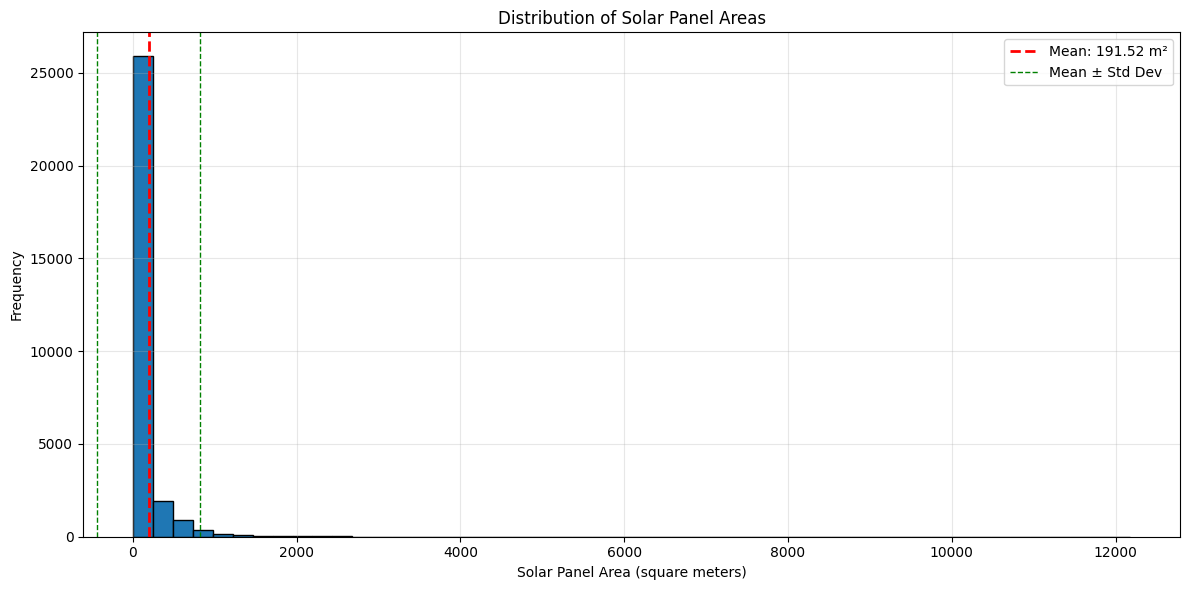

In [12]:
labels_dir = "/content/extracted_label_files/labels/labels_native"
areas = compute_panel_areas(labels_dir)
stats = analyze_areas(areas)
print("\nSolar Panel Area Statistics:")
print("=" * 50)
print(f"Number of panels analyzed: {len(areas)}")
print(f"Mean area: {stats['mean']:.2f} square meters")
print(f"Standard deviation: {stats['std']:.2f} square meters")
print(f"Median area: {stats['median']:.2f} square meters")
print(f"Minimum area: {stats['min']:.2f} square meters")
print(f"Maximum area: {stats['max']:.2f} square meters")


***I could have calculated the area of the solar panel by doing segmentation also for more accurate results (by implementing U-net ,mobilenetv3large or any other model) but due to time constraint I could not perform that .***

In [13]:
def compute_iou(box1, box2):
    box1 = box(*box1)
    box2 = box(*box2)
    intersection = box1.intersection(box2).area
    union = box1.area + box2.area - intersection

    return intersection / union if union > 0 else 0.0

def compute_iou_shapely(box1_yolo, box2_yolo):
    x_center1, y_center1, width1, height1 = box1_yolo
    x_center2, y_center2, width2, height2 = box2_yolo

    box1_mins = (x_center1 - width1/2, y_center1 - height1/2)
    box1_maxs = (x_center1 + width1/2, y_center1 + height1/2)

    box2_mins = (x_center2 - width2/2, y_center2 - height2/2)
    box2_maxs = (x_center2 + width2/2, y_center2 + height2/2)

    shapely_box1 = box(box1_mins[0], box1_mins[1], box1_maxs[0], box1_maxs[1])
    shapely_box2 = box(box2_mins[0], box2_mins[1], box2_maxs[0], box2_maxs[1])

    intersection_area = shapely_box1.intersection(shapely_box2).area
    union_area = shapely_box1.union(shapely_box2).area

    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

def test_iou_implementations():
    test_cases = [
        # Perfect overlap
        ([0.5, 0.5, 0.2, 0.2], [0.5, 0.5, 0.2, 0.2]),
        # No overlap
        ([0.1, 0.1, 0.2, 0.2], [0.8, 0.8, 0.2, 0.2]),
        # Partial overlap
        ([0.5, 0.5, 0.2, 0.2], [0.6, 0.6, 0.2, 0.2]),
        # One box inside another
        ([0.5, 0.5, 0.4, 0.4], [0.5, 0.5, 0.2, 0.2])
    ]

    print("\nComparing IoU Implementations:")
    print("=" * 50)
    for i, (box1, box2) in enumerate(test_cases, 1):
        iou_shapely = compute_iou_shapely(box1, box2)
        iou_manual = compute_iou(box1, box2)

        print(f"\nTest Case {i}:")
        print(f"Box 1: {box1}")
        print(f"Box 2: {box2}")
        print(f"Shapely IoU: {iou_shapely:.4f}")
        print(f"Manual IoU: {iou_manual:.4f}")
        print(f"Difference: {abs(iou_shapely - iou_manual):.6f}")
test_iou_implementations()



Comparing IoU Implementations:

Test Case 1:
Box 1: [0.5, 0.5, 0.2, 0.2]
Box 2: [0.5, 0.5, 0.2, 0.2]
Shapely IoU: 1.0000
Manual IoU: 1.0000
Difference: 0.000000

Test Case 2:
Box 1: [0.1, 0.1, 0.2, 0.2]
Box 2: [0.8, 0.8, 0.2, 0.2]
Shapely IoU: 0.0000
Manual IoU: 0.0000
Difference: 0.000000

Test Case 3:
Box 1: [0.5, 0.5, 0.2, 0.2]
Box 2: [0.6, 0.6, 0.2, 0.2]
Shapely IoU: 0.1429
Manual IoU: 0.5625
Difference: 0.419643

Test Case 4:
Box 1: [0.5, 0.5, 0.4, 0.4]
Box 2: [0.5, 0.5, 0.2, 0.2]
Shapely IoU: 0.2500
Manual IoU: 0.1111
Difference: 0.138889


**Write a function to compute Average Precision (AP) **

Use Pascal VOC 11 point interpolation method to implement the function

Use COCO 101-point interpolation method to implement the function

Use Area under Precision-Recall Curve (AP) method to implement the function

Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods


In [14]:
def compute_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    box1_shape = box(x1, y1, x1 + w1, y1 + h1)
    box2_shape = box(x2, y2, x2 + w2, y2 + h2)
    intersection = box1_shape.intersection(box2_shape).area
    union = box1_shape.union(box2_shape).area

    return intersection / union if union > 0 else 0

def compute_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    # Sorting predictions by confidence score
    sort_idx = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sort_idx]
    pred_scores = pred_scores[sort_idx]

    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)

    # Initializing arrays
    tp = np.zeros(num_pred)
    fp = np.zeros(num_pred)
    gt_matched = np.zeros(num_gt, dtype=bool)

    # Matching predictions to ground truth
    for i, pred_box in enumerate(pred_boxes):
        max_iou = 0
        max_idx = -1

        # Finding best matching ground truth box
        for j, gt_box in enumerate(gt_boxes):
            if not gt_matched[j]:
                iou = compute_iou(pred_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    max_idx = j

        # Assigning prediction as TP or FP
        if max_iou >= iou_threshold and max_idx != -1:
            tp[i] = 1
            gt_matched[max_idx] = True
        else:
            fp[i] = 1

    # Computing cumulative precision and recall
    cumsum_tp = np.cumsum(tp)
    cumsum_fp = np.cumsum(fp)
    precision = cumsum_tp / (cumsum_tp + cumsum_fp)
    recall = cumsum_tp / num_gt if num_gt > 0 else np.zeros_like(cumsum_tp)

    return precision, recall

def compute_ap_voc(precision, recall):
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11
    return ap
def compute_ap_coco(precision, recall):
    ap = 0
    for t in np.arange(0, 1.01, 0.01):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 101
    return ap
def compute_ap_auc(precision, recall):
    # Adding sentinel values
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # Computing the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # Calculating area under PR curve
    indices = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[indices + 1] - mrec[indices]) * mpre[indices + 1])
    return ap
def generate_random_boxes(num_images=10, num_boxes=10, image_size=100, box_size=20):
    all_gt_boxes = []
    all_pred_boxes = []
    all_pred_scores = []

    for _ in range(num_images):
        # Generating ground truth boxes
        gt_boxes = []
        for _ in range(num_boxes):
            x = np.random.randint(0, image_size - box_size)
            y = np.random.randint(0, image_size - box_size)
            gt_boxes.append([x, y, box_size, box_size])

        # Generating predicted boxes with random scores
        pred_boxes = []
        pred_scores = []
        for _ in range(num_boxes):
            x = np.random.randint(0, image_size - box_size)
            y = np.random.randint(0, image_size - box_size)
            pred_boxes.append([x, y, box_size, box_size])
            pred_scores.append(np.random.random())

        all_gt_boxes.append(np.array(gt_boxes))
        all_pred_boxes.append(np.array(pred_boxes))
        all_pred_scores.append(np.array(pred_scores))

    return all_gt_boxes, all_pred_boxes, all_pred_scores


def compare_ap_methods():
    # Generating random test data
    all_gt_boxes, all_pred_boxes, all_pred_scores = generate_random_boxes()
    ap_results = {
        'VOC (11-point)': [],
        'COCO (101-point)': [],
        'AUC': []
    }

    # Computing AP for each image
    for i in range(len(all_gt_boxes)):
        precision, recall = compute_precision_recall(
            all_gt_boxes[i], all_pred_boxes[i], all_pred_scores[i], iou_threshold=0.5
        )

        # Computing AP using different methods
        ap_voc = compute_ap_voc(precision, recall)
        ap_coco = compute_ap_coco(precision, recall)
        ap_auc = compute_ap_auc(precision, recall)

        ap_results['VOC (11-point)'].append(ap_voc)
        ap_results['COCO (101-point)'].append(ap_coco)
        ap_results['AUC'].append(ap_auc)

    print("\nAverage Precision (AP50) Results:")
    print("=" * 50)
    for method, results in ap_results.items():
        mean_ap = np.mean(results)
        std_ap = np.std(results)
        print(f"\n{method}:")
        print(f"Mean AP: {mean_ap:.4f}")
        print(f"Std Dev: {std_ap:.4f}")

    plt.figure(figsize=(10, 6))
    plt.boxplot([ap_results[m] for m in ap_results.keys()], labels=ap_results.keys())
    plt.title('Comparison of AP Calculation Methods')
    plt.ylabel('AP50 Score')
    plt.grid(True, alpha=0.3)
    plt.show()


Average Precision (AP50) Results:

VOC (11-point):
Mean AP: 0.0697
Std Dev: 0.0643

COCO (101-point):
Mean AP: 0.0581
Std Dev: 0.0541

AUC:
Mean AP: 0.0557
Std Dev: 0.0519


<ipython-input-14-85deb3cbc140>:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ap_results[m] for m in ap_results.keys()], labels=ap_results.keys())


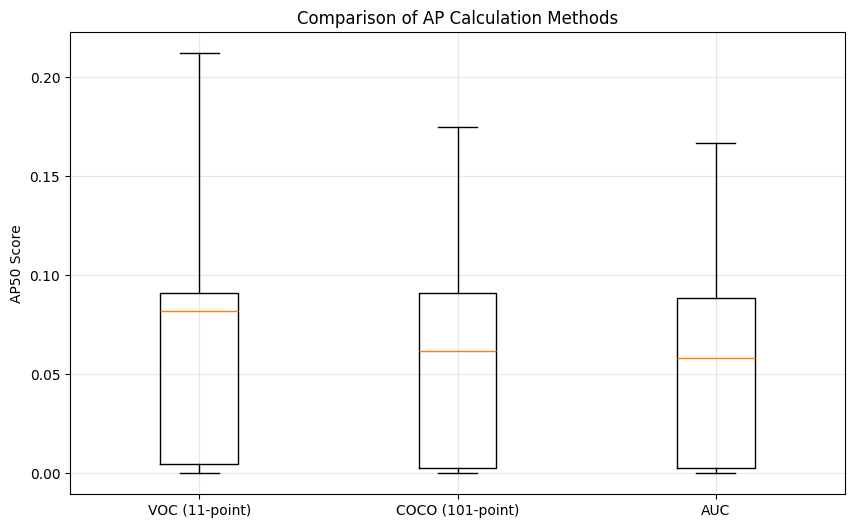

In [15]:
compare_ap_methods()

In [16]:
def generate_test_dataset():
    num_images = 10
    image_size = 100
    box_size = 20
    boxes_per_image = 10

    all_gt_boxes = []
    all_pred_boxes = []
    all_pred_scores = []

    for i in range(num_images):
        # Generating ground truth boxes for this image
        gt_boxes = []
        for _ in range(boxes_per_image):
            # Random position, but fixed size of 20x20
            x = np.random.randint(0, image_size - box_size)
            y = np.random.randint(0, image_size - box_size)
            gt_boxes.append([x, y, box_size, box_size])

        # Generating predicted boxes for this image
        pred_boxes = []
        pred_scores = []
        for _ in range(boxes_per_image):
            # Random position, fixed size, random confidence
            x = np.random.randint(0, image_size - box_size)
            y = np.random.randint(0, image_size - box_size)
            pred_boxes.append([x, y, box_size, box_size])
            # Random confidence score between 0 and 1
            pred_scores.append(np.random.random())

        all_gt_boxes.append(np.array(gt_boxes))
        all_pred_boxes.append(np.array(pred_boxes))
        all_pred_scores.append(np.array(pred_scores))

    return all_gt_boxes, all_pred_boxes, all_pred_scores

def visualize_single_image(gt_boxes, pred_boxes, image_size=100):
    plt.figure(figsize=(8, 8))

    # Create a blank image
    plt.xlim(0, image_size)
    plt.ylim(0, image_size)

    # Plot ground truth boxes in green
    for box in gt_boxes:
        x, y, w, h = box
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='green', label='Ground Truth'))

    # Plot predicted boxes in red
    for box in pred_boxes:
        x, y, w, h = box
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', label='Prediction'))

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Example Image with Ground Truth and Predicted Boxes')
    plt.grid(True)
    plt.show()

def compare_ap_methods(show_example_image=True):

    # Generating the random dataset as specified
    all_gt_boxes, all_pred_boxes, all_pred_scores = generate_test_dataset()

    # Showing an example image if requested
    if show_example_image:
        visualize_single_image(all_gt_boxes[0], all_pred_boxes[0])

    # Storing results for each method
    results = {
        'VOC (11-point)': [],
        'COCO (101-point)': [],
        'AUC': []
    }

    # Computing AP50 for each image using all three methods
    for i in range(len(all_gt_boxes)):
        precision, recall = compute_precision_recall(
            all_gt_boxes[i],
            all_pred_boxes[i],
            all_pred_scores[i],
            iou_threshold=0.5  # Using IoU threshold of 0.5 (AP50)
        )

        # Calculate AP using each method
        results['VOC (11-point)'].append(compute_ap_voc(precision, recall))
        results['COCO (101-point)'].append(compute_ap_coco(precision, recall))
        results['AUC'].append(compute_ap_auc(precision, recall))

    print("\nAP50 Results for Random Dataset:")
    print("=" * 50)
    for method, scores in results.items():
        mean_ap = np.mean(scores)
        std_ap = np.std(scores)
        print(f"\n{method}:")
        print(f"Mean AP50: {mean_ap:.4f}")
        print(f"Std Dev: {std_ap:.4f}")
        print(f"Individual scores: {', '.join([f'{score:.4f}' for score in scores])}")

    plt.figure(figsize=(10, 6))
    plt.boxplot([results[m] for m in results.keys()], labels=results.keys())
    plt.title('Comparison of AP50 Calculation Methods\non Random Dataset')
    plt.ylabel('AP50 Score')
    plt.grid(True, alpha=0.3)
    plt.show()

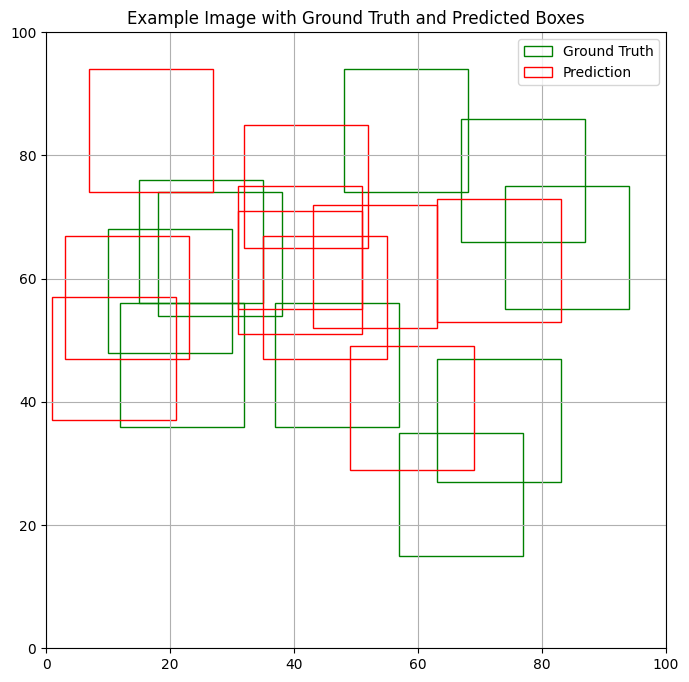


AP50 Results for Random Dataset:

VOC (11-point):
Mean AP50: 0.0863
Std Dev: 0.1154
Individual scores: 0.0000, 0.0000, 0.1818, 0.0000, 0.0000, 0.3273, 0.0202, 0.2424, 0.0000, 0.0909

COCO (101-point):
Mean AP50: 0.0687
Std Dev: 0.0998
Individual scores: 0.0000, 0.0000, 0.1089, 0.0000, 0.0000, 0.2772, 0.0121, 0.2343, 0.0000, 0.0545

AUC:
Mean AP50: 0.0658
Std Dev: 0.0968
Individual scores: 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2700, 0.0111, 0.2267, 0.0000, 0.0500


<ipython-input-16-6cdaa773c733>:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[m] for m in results.keys()], labels=results.keys())


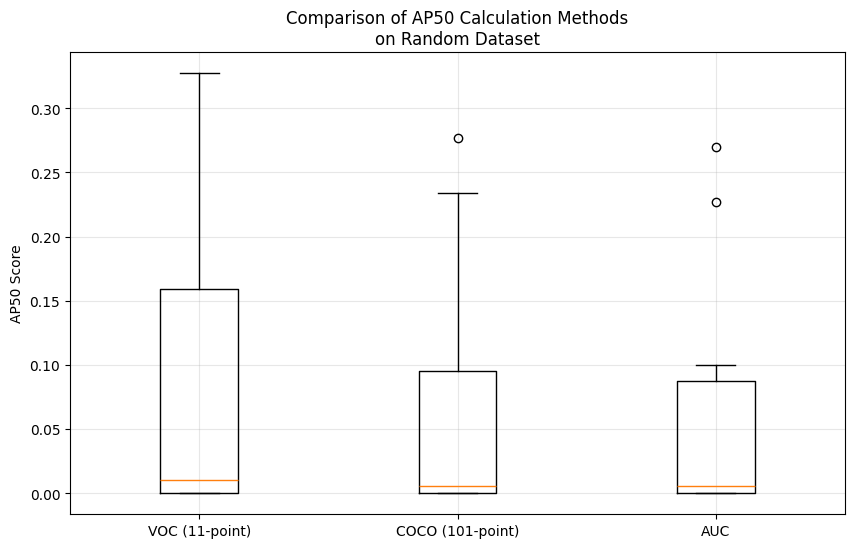

In [17]:
compare_ap_methods()

Split the data into 80-20 train-test split. Use 10% of training data as validation.


In [20]:
zip_path = "/content/drive/MyDrive/Work/SRIP/AISustainability/image_chips_native-20250212T103727Z-001.zip"
extract_path = "/content/extracted_native_images_files"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipping complete! Files are extracted to:", extract_path)

Unzipping complete! Files are extracted to: /content/extracted_native_images_files


In [18]:
def get_matching_files(image_dir, label_dir):
    label_files = set(f.replace('.txt', '') for f in os.listdir(label_dir)
                     if f.endswith('.txt'))
    image_files = set(f.replace('.tif', '') for f in os.listdir(image_dir)
                     if f.endswith('.tif'))
    common_files = label_files.intersection(image_files)
    assert len(common_files) == 2542, f"Found {len(common_files)} matches, expected 2542"
    matching_pairs = [(f + '.tif', f + '.txt') for f in common_files]

    return matching_pairs

class SolarPanelDataSplitter:
    def __init__(self, native_images_dir, native_labels_dir):
        self.native_images_dir = native_images_dir
        self.native_labels_dir = native_labels_dir

    def get_matching_files(self):

        label_files = {f.replace('.txt', '') for f in os.listdir(self.native_labels_dir)
                      if f.endswith('.txt')}


        image_files = {f.replace('.tif', '') for f in os.listdir(self.native_images_dir)
                      if f.endswith('.tif')}


        common_files = sorted(list(label_files.intersection(image_files)))


        assert len(common_files) == 2542, f"Found {len(common_files)} matches, expected 2542"
        matched_pairs = [(
            os.path.join(self.native_images_dir, f + '.tif'),
            os.path.join(self.native_labels_dir, f + '.txt')
        ) for f in common_files]

        return matched_pairs

    def create_split_directories(self, output_base_dir):
        directories = [
            'train/images', 'train/labels',
            'val/images', 'val/labels',
            'test/images', 'test/labels'
        ]
        for dir_path in directories:
            full_path = os.path.join(output_base_dir, dir_path)
            os.makedirs(full_path, exist_ok=True)

        return output_base_dir

    def copy_files(self, file_pairs, output_base_dir, split_type):
        for img_path, label_path in file_pairs:
            img_name = os.path.basename(img_path)
            label_name = os.path.basename(label_path)

            img_dest = os.path.join(output_base_dir, split_type, 'images', img_name)
            label_dest = os.path.join(output_base_dir, split_type, 'labels', label_name)

            shutil.copy2(img_path, img_dest)
            shutil.copy2(label_path, label_dest)

    def split_dataset(self, output_base_dir, test_size=0.2, val_size=0.1, random_state=42):
        matched_pairs = self.get_matching_files()
        self.create_split_directories(output_base_dir)
        train_val_pairs, test_pairs = train_test_split(
            matched_pairs,
            test_size=test_size,
            random_state=random_state
        )
        train_pairs, val_pairs = train_test_split(
            train_val_pairs,
            test_size=val_size,
            random_state=random_state
        )
        self.copy_files(train_pairs, output_base_dir, 'train')
        self.copy_files(val_pairs, output_base_dir, 'val')
        self.copy_files(test_pairs, output_base_dir, 'test')
        stats = {
            'total_pairs': len(matched_pairs),
            'train_pairs': len(train_pairs),
            'val_pairs': len(val_pairs),
            'test_pairs': len(test_pairs),
            'train_percentage': len(train_pairs) / len(matched_pairs) * 100,
            'val_percentage': len(val_pairs) / len(matched_pairs) * 100,
            'test_percentage': len(test_pairs) / len(matched_pairs) * 100
        }

        return stats

In [21]:
# Initializing the splitter
splitter = SolarPanelDataSplitter(
    native_images_dir='/content/extracted_native_images_files/image_chips_native',
    native_labels_dir='/content/extracted_label_files/labels/labels_native'
)

# Performing the split
stats = splitter.split_dataset(
    output_base_dir='/content/output_dir',
    test_size=0.2,
    val_size=0.1,
    random_state=42 # for reproducibility
)
print("Dataset Split Statistics:")
print(f"Total pairs: {stats['total_pairs']}")
print(f"Training pairs: {stats['train_pairs']} ({stats['train_percentage']:.1f}%)")
print(f"Validation pairs: {stats['val_pairs']} ({stats['val_percentage']:.1f}%)")
print(f"Test pairs: {stats['test_pairs']} ({stats['test_percentage']:.1f}%)")

Dataset Split Statistics:
Total pairs: 2542
Training pairs: 1829 (72.0%)
Validation pairs: 204 (8.0%)
Test pairs: 509 (20.0%)


In [22]:
dataset_yaml_path = "/content/output_dir/dataset.yaml"
dataset_config = {
    "train": "/content/output_dir/train/images",
    "val": "/content/output_dir/val/images",
    "test": "/content/output_dir/test/images",
    "nc": 3,
    "names": ["solar_panel_0", "solar_panel_1", "solar_panel_2"]
}
os.makedirs(os.path.dirname(dataset_yaml_path), exist_ok=True)
with open(dataset_yaml_path, "w") as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"dataset.yaml created successfully at: {dataset_yaml_path}")

dataset.yaml created successfully at: /content/output_dir/dataset.yaml


In [25]:


def get_paths():
    """Get user input for dataset paths."""
    train_images_dir = "/content/output_dir/train"
    val_images_dir = "/content/output_dir/val"
    test_images_dir = "/content/output_dir/test"
    dataset_yaml_path = "/content/output_dir/dataset.yaml"

    # Verify paths exist
    for path in [train_images_dir, val_images_dir, test_images_dir, dataset_yaml_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path not found: {path}")

    return train_images_dir, val_images_dir, test_images_dir, dataset_yaml_path

def prepare_tif_conversion(train_dir, val_dir, test_dir):
    """Create temporary directories for PNG conversions if needed."""
    # Check if files are TIF and need conversion
    sample_file = os.listdir(train_dir)[0]
    needs_conversion = sample_file.lower().endswith('.tif') or sample_file.lower().endswith('.tiff')

    if needs_conversion:
        print("TIF files detected. Will convert to PNG for YOLOv8 compatibility.")
        temp_dirs = {}
        for dir_name, orig_dir in [('train', train_dir), ('val', val_dir), ('test', test_dir)]:
            # Create temp directory
            parent_dir = os.path.dirname(os.path.dirname(orig_dir))
            temp_dir = os.path.join(parent_dir, f"temp_{dir_name}_images")
            os.makedirs(temp_dir, exist_ok=True)
            temp_dirs[dir_name] = temp_dir
        return True, temp_dirs

    return False, None

def convert_tif_to_png(original_dir, temp_dir):
    """Convert TIF images to PNG for better compatibility with YOLOv8."""
    print(f"Converting TIF images in {original_dir} to PNG...")

    # Get all TIF files
    tif_files = [f for f in os.listdir(original_dir) if f.lower().endswith(('.tif', '.tiff'))]

    # Convert each file
    for tif_file in tqdm(tif_files):
        try:
            # Open TIF image
            img_path = os.path.join(original_dir, tif_file)
            img = Image.open(img_path)

            # Handle multi-band images by converting to RGB if needed
            if img.mode not in ['RGB', 'L']:
                img = img.convert('RGB')

            # Save as PNG
            png_filename = os.path.splitext(tif_file)[0] + '.png'
            png_path = os.path.join(temp_dir, png_filename)
            img.save(png_path)
        except Exception as e:
            print(f"Error converting {tif_file}: {str(e)}")

    return len(tif_files)

def update_yaml_paths(yaml_path, temp_dirs=None):
    """Update the YAML file with temporary directory paths if needed."""
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    # Store original paths
    original_paths = {
        'train': config['train'],
        'val': config['val'],
        'test': config['test'],
    }

    if temp_dirs:
        # Update with temp directories
        config['train'] = temp_dirs['train']
        config['val'] = temp_dirs['val']
        config['test'] = temp_dirs['test']

        with open(yaml_path, 'w') as f:
            yaml.dump(config, f)

    return original_paths, config

def copy_label_files(dataset_dir, temp_dirs=None):
    """Copy label files to match the converted PNG images."""
    if not temp_dirs:
        return

    for dir_type in ['train', 'val', 'test']:
        # Determine source and destination paths
        images_dir = os.path.join(dataset_dir, dir_type, 'images')
        labels_dir = os.path.join(dataset_dir, dir_type, 'labels')
        temp_labels_dir = os.path.join(os.path.dirname(temp_dirs[dir_type]), 'labels')

        # Create destination directory
        os.makedirs(temp_labels_dir, exist_ok=True)

        # Get all label files
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

        print(f"Copying {len(label_files)} label files for {dir_type}...")

        # Copy each label file
        for label_file in tqdm(label_files):
            # Get the corresponding image base name (remove extension)
            base_name = os.path.splitext(label_file)[0]

            # Source and destination paths
            src_path = os.path.join(labels_dir, label_file)
            dest_path = os.path.join(temp_labels_dir, label_file)

            # Copy the file
            shutil.copy2(src_path, dest_path)

def train_yolov8_model(yaml_path, epochs=3, img_size=640, batch_size=16, patience=20):
    """Train YOLOv8 model with the provided dataset."""
    print(f"Starting YOLOv8 training for {epochs} epochs with image size {img_size}...")

    # Create output directory
    output_dir = os.path.join(os.path.dirname(yaml_path), 'yolov8_results')
    os.makedirs(output_dir, exist_ok=True)

    # Initialize model (YOLOv8n by default)
    model = YOLO('yolov8n.pt')

    # Train the model with early stopping
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        patience=patience,
        project=output_dir,
        name='solar_panel_detection',
        verbose=True,
        exist_ok=True
    )

    print(f"Training completed. Results saved to {output_dir}/solar_panel_detection")
    return model, os.path.join(output_dir, 'solar_panel_detection')

def validate_model(model, dataset_yaml):
    """Validate the trained model and visualize results."""
    print("Validating model...")

    # Validate on validation set
    val_results = model.val()

    # Print validation metrics
    print(f"Validation Results:")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")

    # If you want to print precision for each class
    for i, p in enumerate(val_results.box.p):
        print(f"Precision (Class {i}): {p:.4f}")

    # If you want to print recall for each class
    for i, r in enumerate(val_results.box.r):
        print(f"Recall (Class {i}): {r:.4f}")

    return val_results

def visualize_training_results(results_dir):
    """Visualize training and validation metrics from the results directory."""
    try:
        # Load the results CSV
        results_file = os.path.join(results_dir, 'results.csv')
        if not os.path.exists(results_file):
            print(f"Results file not found at {results_file}")
            return

        # Load data
        data = np.loadtxt(results_file, delimiter=',', skiprows=1)

        # Extract metrics
        epochs = data[:, 0]
        train_loss = data[:, 1]
        val_loss = data[:, 2]
        mAP50 = data[:, 3]

        # Create plots
        plt.figure(figsize=(15, 10))

        # Plot training and validation loss
        plt.subplot(2, 1, 1)
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Highlight convergence
        converged = is_converged(val_loss)
        if converged:
            conv_epoch = find_convergence_epoch(val_loss)
            plt.axvline(x=conv_epoch, color='r', linestyle='--',
                        label=f'Converged at epoch {conv_epoch}')
            plt.text(conv_epoch+1, min(val_loss), f'Convergence reached',
                     color='red', fontsize=10)

        # Plot mAP50
        plt.subplot(2, 1, 2)
        plt.plot(epochs, mAP50, label='mAP@0.5', color='green')
        plt.title('Mean Average Precision (mAP@0.5)')
        plt.xlabel('Epoch')
        plt.ylabel('mAP@0.5')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        # Save the plot
        plot_path = os.path.join(results_dir, 'training_metrics.png')
        plt.savefig(plot_path)
        plt.close()

        print(f"Training visualization saved to {plot_path}")

        # Print convergence information
        if converged:
            print(f"Validation loss converged at epoch {conv_epoch}")
            print(f"Final validation loss: {val_loss[-1]:.4f}")
            print(f"Final mAP@0.5: {mAP50[-1]:.4f}")
        else:
            print("Validation loss did not converge. Consider training for more epochs.")

        return plot_path

    except Exception as e:
        print(f"Error visualizing results: {str(e)}")
        return None

def is_converged(val_loss, window=10, threshold=0.01):
    """Check if validation loss has converged."""
    if len(val_loss) < window + 1:
        return False

    # Calculate moving average of improvement
    improvements = []
    for i in range(len(val_loss) - window):
        start_loss = val_loss[i]
        end_loss = val_loss[i + window]
        relative_improvement = (start_loss - end_loss) / start_loss if start_loss > 0 else 0
        improvements.append(relative_improvement)

    # Check if recent improvements are below threshold
    if len(improvements) >= 3:
        recent_avg_improvement = np.mean(improvements[-3:])
        return recent_avg_improvement < threshold

    return False

def find_convergence_epoch(val_loss, window=10, threshold=0.01):
    """Find the epoch where convergence started."""
    if len(val_loss) < window + 1:
        return len(val_loss) - 1

    for i in range(len(val_loss) - window):
        start_loss = val_loss[i]
        end_loss = val_loss[i + window]
        relative_improvement = (start_loss - end_loss) / start_loss if start_loss > 0 else 0

        if relative_improvement < threshold:
            return i + window

    return len(val_loss) - 1

def visualize_predictions(model, test_dir, num_samples=5):
    """Visualize model predictions on random test images."""
    print(f"Visualizing predictions on {num_samples} random test images...")

    # Get test images
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

    if len(test_images) == 0:
        print(f"No compatible images found in {test_dir}")
        return None

    # Select random samples
    samples = random.sample(test_images, min(num_samples, len(test_images)))

    # Create figure for visualization
    fig, axes = plt.subplots(1, len(samples), figsize=(5*len(samples), 5))
    if len(samples) == 1:
        axes = [axes]

    # Process each sample
    for i, sample in enumerate(samples):
        img_path = os.path.join(test_dir, sample)

        # For TIF images, convert to array using PIL first
        if sample.lower().endswith(('.tif', '.tiff')):
            img = Image.open(img_path)
            if img.mode not in ['RGB', 'L']:
                img = img.convert('RGB')
            img = np.array(img)
        else:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Run prediction
        results = model(img)

        # Get result image with boxes
        plot = results[0].plot()

        # Display in subplot
        axes[i].imshow(plot)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()

    # Save visualization
    output_dir = os.path.dirname(os.path.dirname(test_dir))
    vis_path = os.path.join(output_dir, 'prediction_samples.png')
    plt.savefig(vis_path)
    plt.close()

    print(f"Prediction visualization saved to {vis_path}")
    return vis_path

def cleanup_temp_files(temp_dirs):
    """Clean up temporary directories created for PNG conversion."""
    if not temp_dirs:
        return

    print("Cleaning up temporary files...")
    for dir_name, dir_path in temp_dirs.items():
        if os.path.exists(dir_path):
            print(f"Removing temporary {dir_name} directory")
            shutil.rmtree(dir_path)

    # Also try to remove the temp label directories
    for dir_name, dir_path in temp_dirs.items():
        temp_labels_dir = os.path.join(os.path.dirname(dir_path), 'labels')
        if os.path.exists(temp_labels_dir):
            print(f"Removing temporary labels directory for {dir_name}")
            shutil.rmtree(temp_labels_dir)

def main():
    """Main function to run the complete YOLOv8 training pipeline."""
    print("🌞 Solar Panel Detection using YOLOv8 🌞")
    print("=========================================")

    try:
        # Get paths from user
        train_dir, val_dir, test_dir, yaml_path = get_paths()

        # Check if files are TIF and need conversion
        needs_conversion, temp_dirs = prepare_tif_conversion(train_dir, val_dir, test_dir)

        # Convert TIF to PNG if needed
        if needs_conversion:
            for dir_type, orig_dir, temp_dir in [
                ('training', train_dir, temp_dirs['train']),
                ('validation', val_dir, temp_dirs['val']),
                ('test', test_dir, temp_dirs['test'])
            ]:
                num_converted = convert_tif_to_png(orig_dir, temp_dir)
                print(f"Converted {num_converted} {dir_type} images to PNG")

            # Copy label files to match converted PNGs
            dataset_dir = os.path.dirname(os.path.dirname(train_dir))
            copy_label_files(dataset_dir, temp_dirs)

            # Update YAML paths
            original_paths, config = update_yaml_paths(yaml_path, temp_dirs)
        else:
            original_paths, config = update_yaml_paths(yaml_path)

        # Set device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")

        # Train model
        model, results_dir = train_yolov8_model(
            yaml_path,
            epochs=3,  # You can adjust these parameters
            img_size=640,
            batch_size=16,
            patience=20
        )

        # Validate model
        val_results = validate_model(model, yaml_path)

        # Visualize training results
        plot_path = visualize_training_results(results_dir)

        # Visualize predictions on test set
        test_img_dir = temp_dirs['test'] if needs_conversion else test_dir
        vis_path = visualize_predictions(model, test_img_dir, num_samples=5)

        # Print final summary
        print("\n===== Training Summary =====")
        print(f"Model trained successfully for {config['names'][0]} detection")
        print(f"Results saved to: {results_dir}")
        if plot_path:
            print(f"Training plot saved to: {plot_path}")
        if vis_path:
            print(f"Prediction samples saved to: {vis_path}")

        # Clean up temporary files if needed
        if needs_conversion:
            cleanup_temp_files(temp_dirs)

            # Restore original YAML paths
            update_yaml_paths(yaml_path, original_paths)

        print("\nTraining pipeline completed successfully!")

    except Exception as e:
        print(f"Error in training pipeline: {str(e)}")
        import traceback
        traceback.print_exc()



100%|██████████| 6.25M/6.25M [00:00<00:00, 103MB/s]


Starting YOLOv8 model training...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8n.pt, data=/content/output_dir/dataset.yaml, epochs=10, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=solar_panel_detection, name=yolov8n_train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.8MB/s]


AMP: checks passed ✅


train: Scanning /content/output_dir/train/labels... 1829 images, 0 backgrounds, 171 corrupt: 100%|██████████| 1829/1829 [00:01<00:00, 1460.88it/s]

train: WARNING ⚠️ /content/output_dir/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/output_dir/train/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/output_dir/train/images/solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/output_dir/train/images/solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/output_dir/train/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1.

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/output_dir/val/labels... 204 images, 0 backgrounds, 25 corrupt: 100%|██████████| 204/204 [00:00<00:00, 854.81it/s] 

val: WARNING ⚠️ /content/output_dir/val/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/output_dir/val/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/output_dir/val/images/solarpanels_native_1__x0_1536_y0_10086_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/output_dir/val/images/solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/output_dir/val/images/solarpanels_native_1__x0_299_y0_7578_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class l

Plotting labels to solar_panel_detection/yolov8n_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to solar_panel_detection/yolov8n_train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.14G       1.76      1.981      1.323         68        416: 100%|██████████| 104/104 [00:18<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


                   all        179       2141      0.684      0.439      0.546      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.08G      1.502      1.246      1.148        126        416: 100%|██████████| 104/104 [00:17<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

                   all        179       2141      0.547       0.54      0.506      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.19G      1.441      1.121      1.145        161        416: 100%|██████████| 104/104 [00:15<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]

                   all        179       2141      0.715      0.614      0.699       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.17G      1.414      1.056      1.121        121        416: 100%|██████████| 104/104 [00:15<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]

                   all        179       2141      0.782      0.697      0.779      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.15G      1.363     0.9603      1.096        118        416: 100%|██████████| 104/104 [00:15<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


                   all        179       2141      0.814      0.745      0.824       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.02G      1.292     0.8967       1.06         65        416: 100%|██████████| 104/104 [00:16<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all        179       2141      0.853      0.783      0.864      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.19G      1.235      0.838      1.038         91        416: 100%|██████████| 104/104 [00:15<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]

                   all        179       2141      0.858      0.797      0.875      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.08G      1.188      0.797      1.016        205        416: 100%|██████████| 104/104 [00:15<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.74it/s]

                   all        179       2141      0.853      0.817      0.891      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.26G      1.148     0.7531     0.9969         59        416: 100%|██████████| 104/104 [00:15<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]

                   all        179       2141      0.872      0.818      0.903      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.14G      1.111     0.7246     0.9877         76        416: 100%|██████████| 104/104 [00:16<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

                   all        179       2141      0.886      0.824      0.914      0.651



10 epochs completed in 0.052 hours.
Optimizer stripped from solar_panel_detection/yolov8n_train/weights/last.pt, 6.2MB
Optimizer stripped from solar_panel_detection/yolov8n_train/weights/best.pt, 6.2MB

Validating solar_panel_detection/yolov8n_train/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


                   all        179       2141      0.884      0.828      0.914      0.651
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to solar_panel_detection/yolov8n_train
Training complete!
Available attributes in results: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ap_class_index', 'box', 'class_result', 'confusion_matrix', 'curves', 'curves_results', 'fitness', 'keys', 'maps', 'mean_results', 'names', 'plot', 'process', 'results_dict', 'save_dir', 'speed', 'task']
Visualizing predictions...

image 1/1 /content/output_dir/val/images/solarpanels_native_3__x0_8544_y0_9199_dxdy_416.tif: 416x416 4 solar_panels

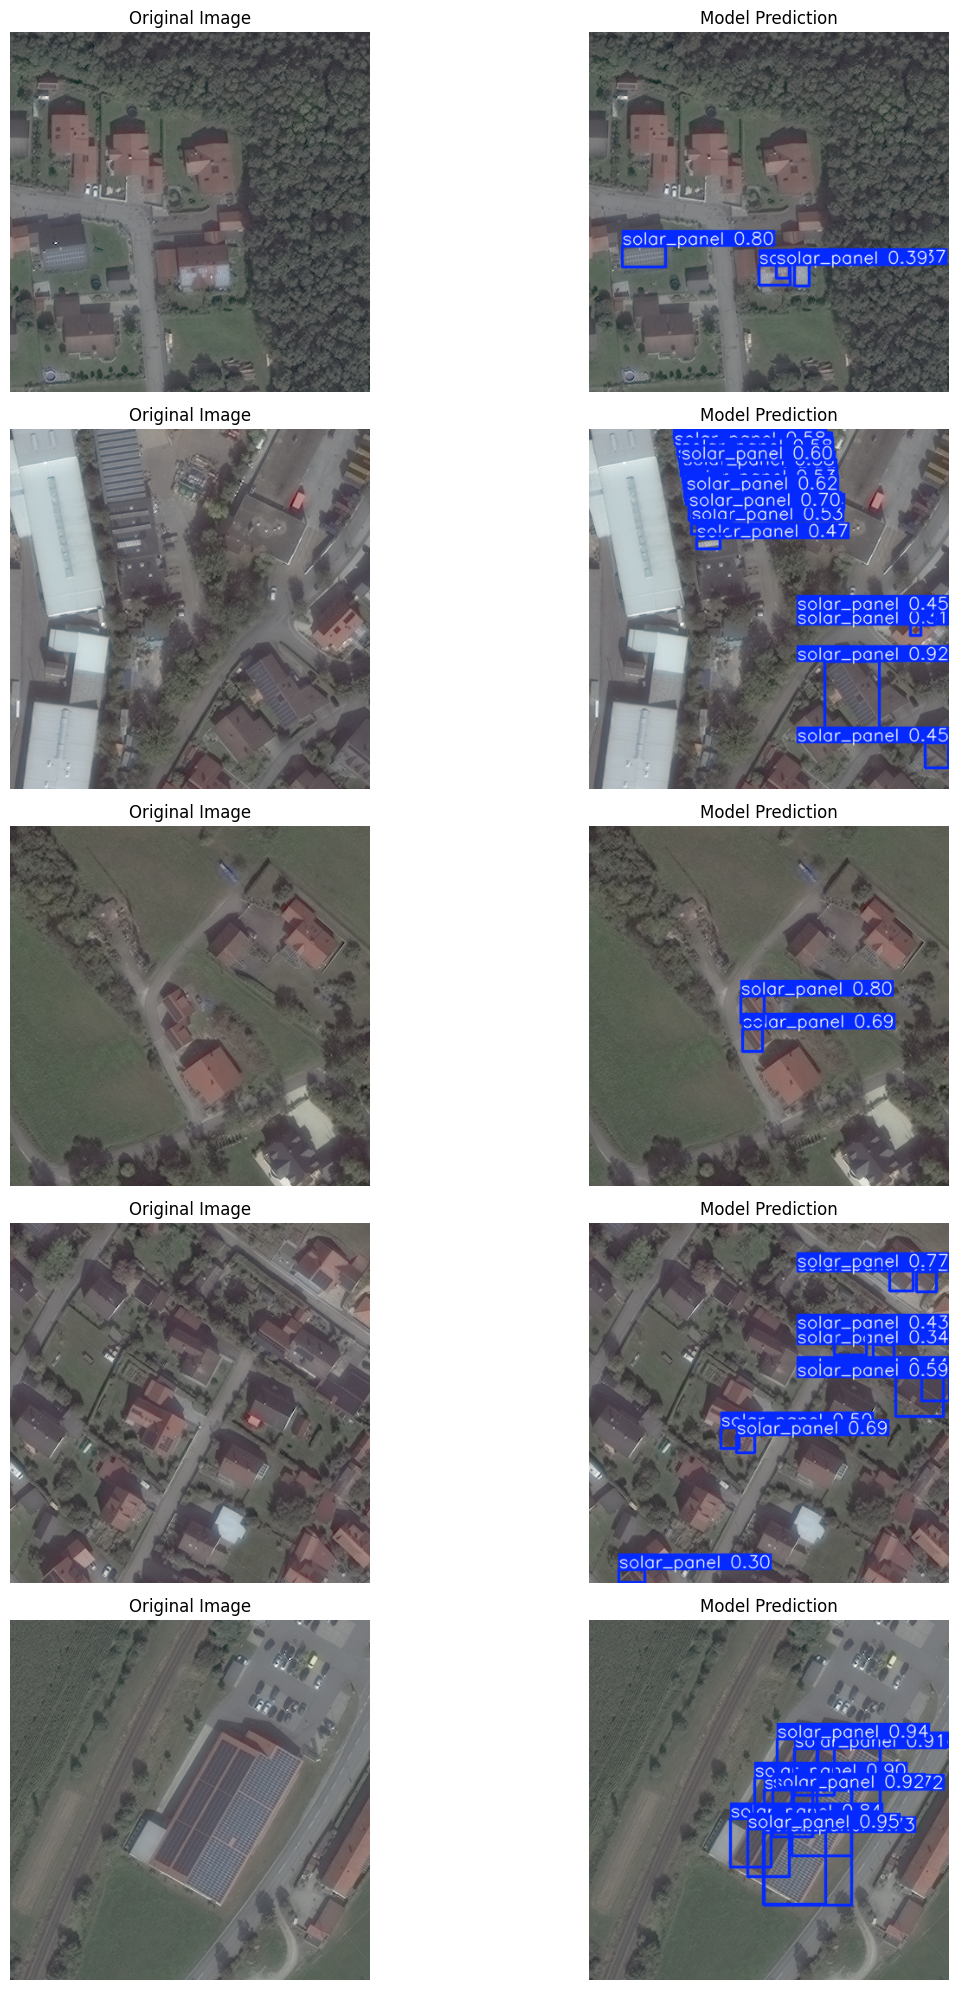

Predictions visualized successfully!


In [26]:
if __name__ == "__main__":
    main()

Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. **bold text**